## Описание проекта и данных

Кредитному отделу банка необходимо разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок.

Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

# Проект "Исследование надежности заемщиков"

### Описание данных

* `children` — количество детей в семье
* `days_employed` — общий трудовой стаж в днях
* `dob_years` — возраст клиента в годах
* `education` — уровень образования клиента
* `education_id` — идентификатор уровня образования
* `family_status` — семейное положение
* `family_status_id` — идентификатор семейного положения
* `gender` — пол клиента
* `income_type` — тип занятости
* `debt` — имел ли задолженность по возврату кредитов
* `total_income` — ежемесячный доход
* `purpose` — цель получения кредита


## Изучение общей информации о данных


In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [41]:
try:
    df = pd.read_csv('scoring_data.csv')
except FileNotFoundError:
    print('файл не найден')

In [42]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


В таблице 12 столбцов по 21525 записей. Тип данных в столбцах соответствуют хранящимся в них данных.

В названиях колонок нарушений стиля не обнаружено. Переименовывать столбцы нет необходимости.

Количество значений в столбцах различается. Значит, в данных есть пропущенные значения.

### Вывод

В каждой строке таблицы — данные о заемщиках банка. Часть колонок описывает клиента: общий трудовой стаж, возраст, уровень образования, семейное положение, пол, тип занятости, ежемесячный доход. Столбцы `education_id` и `family_status_id` выполняют роль перевода качественной характеристики заемщика в количественную, т.е. ставят в соответствие статусу семейного положения и уровня образования метку. Поэтому в целом можно сказать, что данные столбцов `education` и `family_status` продублированы в соответствии с их количественными идентификаторами и могут быть удалены из датасета из-за отсутствия информативности.
Столбцы `debt` и `purpose` характеризуют клиента относительно процедуры кредитования, учитывают его кредитную историю.

Устраним проблемы в данных.

## Предобработка данных

### Пропуски


In [44]:
# подсчёт пропусков
df.isnull()
df.isnull().mean()

children            0.000000
days_employed       0.100999
dob_years           0.000000
education           0.000000
education_id        0.000000
family_status       0.000000
family_status_id    0.000000
gender              0.000000
income_type         0.000000
debt                0.000000
total_income        0.100999
purpose             0.000000
dtype: float64

В столбцах `days_employed` и `total_income` имеются одинаковое количество пропущенных значений. Оба столбца - количественные, поэтому пропуски логично заполнить числовыми значениями.


Пропуски составляют 10% от объема данных в соответствующих столбцах, удалять такое не следует, достаточный объем данных для изменения основных характеристик.

Возможно, пропуски связаны с отсутствием занятости клиента, поэтому у него нет среднего дохода и стажа работы. Это вполне логично. Т.к. доля пропущенных значений невелика, то это не сильно повлияет на итоговый результат. Но эти пропуски могут быть связаны либо с отсутствием информации по этим пунктам, либо просто с отсутствием постоянного дохода и места работы заемщика.  Но в столбце `income_type` пропусков нет. Поэтому есть предположение, что сотрудники банка просто не внесли данную информацию при заполнении анкеты.

In [45]:
# Заменим пропущенные значения медианными значениями по соответствующим столбцам
df['days_employed'].fillna(df['days_employed'].median(), inplace=True)
df['total_income'].fillna(df['total_income'].median(), inplace=True)
# проверка заполненности пропусков
df.isnull().mean()

children            0.0
days_employed       0.0
dob_years           0.0
education           0.0
education_id        0.0
family_status       0.0
family_status_id    0.0
gender              0.0
income_type         0.0
debt                0.0
total_income        0.0
purpose             0.0
dtype: float64

### Изменение типа данных


Заменим вещественный тип данных в столбце `total_income` на целочисленный с помощью метода `astype()`.

In [46]:
df['total_income'] = df['total_income'].astype('int')
df.dtypes

children              int64
days_employed       float64
dob_years             int64
education            object
education_id          int64
family_status        object
family_status_id      int64
gender               object
income_type          object
debt                  int64
total_income          int32
purpose              object
dtype: object

### Дубликаты

In [47]:
# подсчёт явных дубликатов
df.duplicated().sum()

54

In [48]:
# удаление явных дубликатов (с удалением старых индексов и формирование новых)
df = df.drop_duplicates().reset_index(drop=True)

# проверка на отсутствие дубликатов
df.duplicated().sum()

0

Определим все уникальные записи в столбце `education`. 

In [49]:
df['education'].sort_values().unique()

array(['ВЫСШЕЕ', 'Высшее', 'НАЧАЛЬНОЕ', 'НЕОКОНЧЕННОЕ ВЫСШЕЕ',
       'Начальное', 'Неоконченное высшее', 'СРЕДНЕЕ', 'Среднее',
       'УЧЕНАЯ СТЕПЕНЬ', 'Ученая степень', 'высшее', 'начальное',
       'неоконченное высшее', 'среднее', 'ученая степень'], dtype=object)

Видим, что названия записаны в разном регистре, поэтому переведем все записи в нижний регистр для устрания неявных дубликатов и выведем полученный список уникальных значений.

In [50]:
df['education'] = df['education'].str.lower()
df['education'].sort_values().unique()

array(['высшее', 'начальное', 'неоконченное высшее', 'среднее',
       'ученая степень'], dtype=object)

Проверим, появились ли после такой замены дубликаты в явном виде. Снова применим метод `duplicated()`

In [51]:
df.duplicated().sum()

17

In [52]:
#Дубликаты остались, поэтому удалим эти явные дубликаты (с удалением старых индексов и формированием новых)
df = df.drop_duplicates().reset_index(drop=True)
# проверка на отсутствие дубликатов
df.duplicated().sum()

0

In [53]:
# Выведем на экран список уникальных названий family_status, отсортированный в алфавитном порядке
df['family_status'].value_counts(normalize=True)

family_status
женат / замужем          0.575138
гражданский брак         0.193484
Не женат / не замужем    0.130978
в разводе                0.055701
вдовец / вдова           0.044700
Name: proportion, dtype: float64

В столбце `family_status` неявных дубликатов не обнаружено.

In [54]:
# Выведем на экран список уникальных названий income_type, отсортированный в алфавитном порядке
df['income_type'].sort_values().value_counts(normalize=True)

income_type
сотрудник          0.516640
компаньон          0.236692
пенсионер          0.178475
госслужащий        0.067913
безработный        0.000093
предприниматель    0.000093
в декрете          0.000047
студент            0.000047
Name: proportion, dtype: float64

В столбце `income_type` неявных дубликатов не обнаружено.

In [55]:
# Выведем на экран список уникальных названий purpose, отсортированный в алфавитном порядке
df['purpose'].sort_values().unique()

array(['автомобили', 'автомобиль', 'высшее образование',
       'дополнительное образование', 'жилье',
       'заняться высшим образованием', 'заняться образованием',
       'на покупку автомобиля', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля', 'на проведение свадьбы',
       'недвижимость', 'образование', 'операции с жильем',
       'операции с коммерческой недвижимостью',
       'операции с недвижимостью', 'операции со своей недвижимостью',
       'покупка жилой недвижимости', 'покупка жилья',
       'покупка жилья для сдачи', 'покупка жилья для семьи',
       'покупка коммерческой недвижимости', 'покупка недвижимости',
       'покупка своего жилья', 'получение высшего образования',
       'получение дополнительного образования', 'получение образования',
       'приобретение автомобиля', 'профильное образование',
       'ремонт жилью', 'свадьба', 'свой автомобиль',
       'сделка с автомобилем', 'сделка с подержанным автомобилем',
       'строительство 

Многие записи дублируют друг друга, но имеют различную формулировку. Скорее всего, наличие такого большого количества различных записей связано со свободной формой заполнения соответствующих данных и отсутствием единого формата.



### Аномальные значения

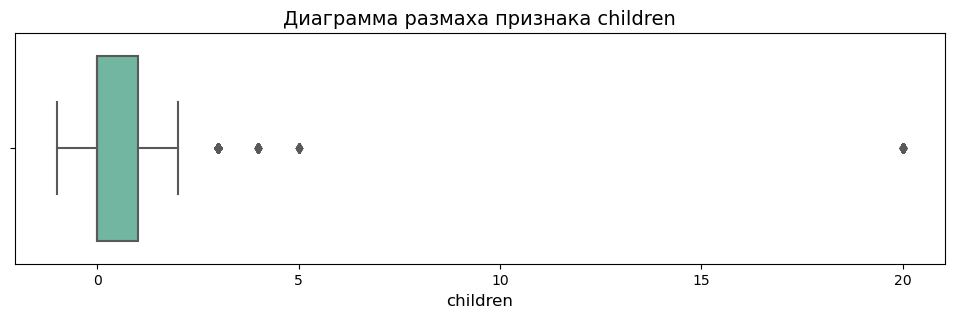

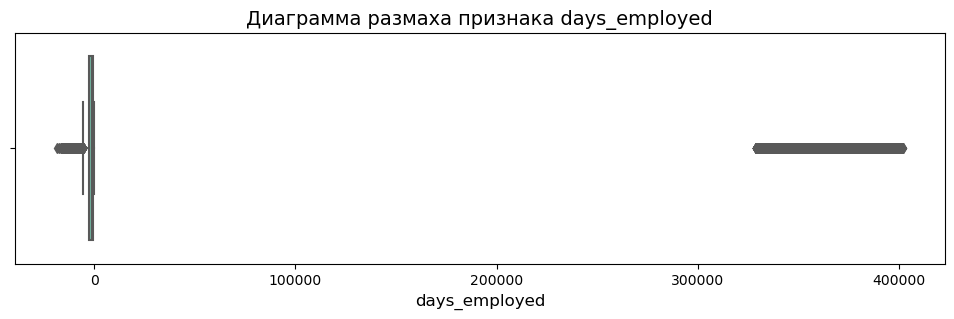

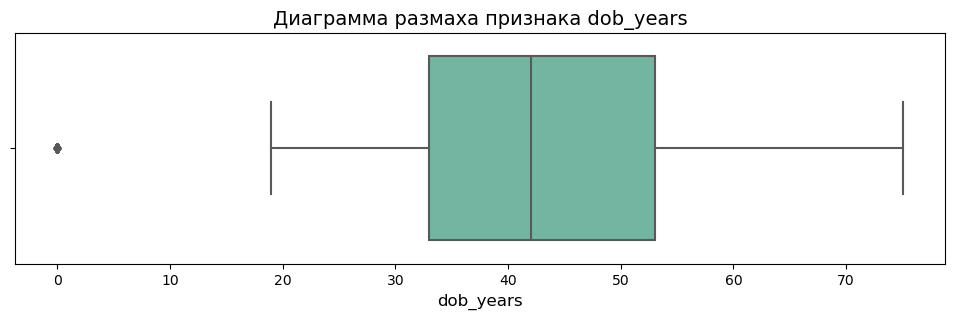

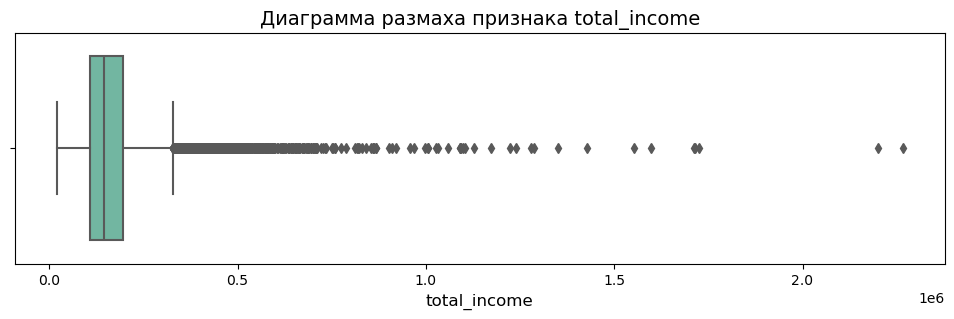

In [56]:
sns.set_palette('Set2')
for name in ['children', 'days_employed', 'dob_years', 'total_income']:
    fig = plt.figure(figsize = (12,3))
    plt.title(f"Диаграмма размаха признака "+name, fontsize=14)
    sns.boxplot(x = df[name])

    plt.xlabel(name, fontsize = 12)
    plt.show()

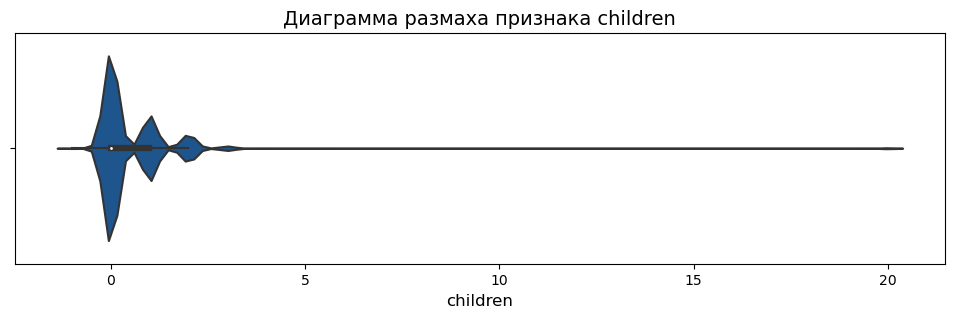

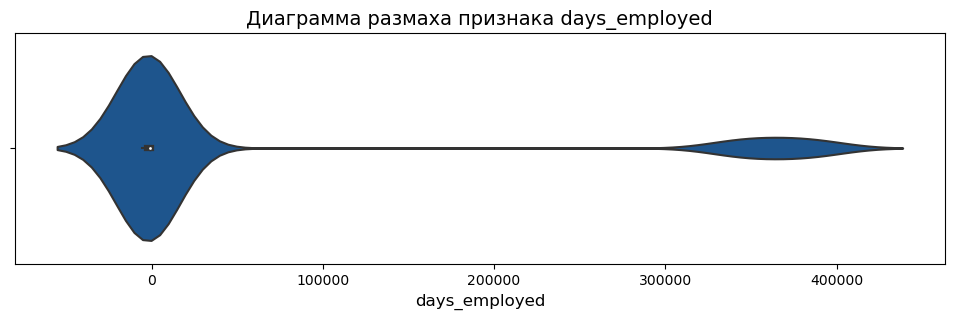

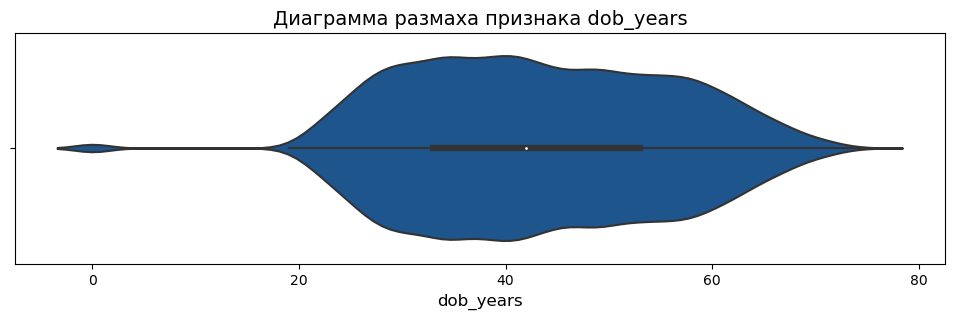

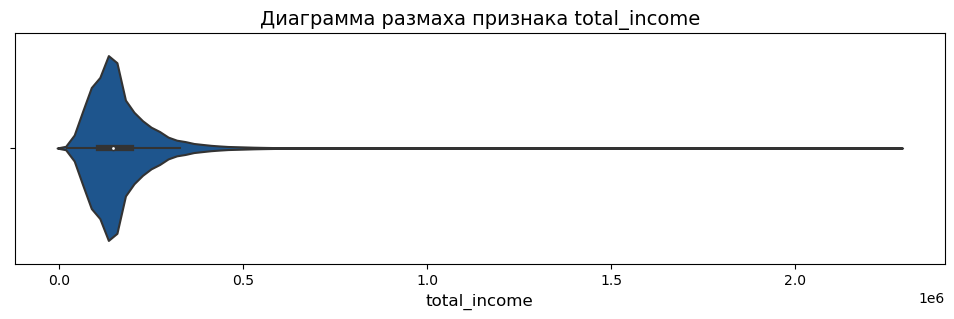

In [57]:
sns.set_palette('Blues_r')
for name in ['children', 'days_employed', 'dob_years', 'total_income']:
    fig = plt.figure(figsize = (12,3))
    plt.title(f"Диаграмма размаха признака "+name, fontsize=14)
    sns.violinplot(x = df[name])

    plt.xlabel(name, fontsize = 12)
    plt.show()

Оценим статистические характеристики числовых признаков.

In [58]:
# Выведем описательную статистику и проанализируем полученные результаты
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000,2.145400e+04
mean,0.539946,56748.489332,43.271231,0.817097,0.973898,0.081150,1.652256e+05
std,1.383444,135104.409125,12.570822,0.548674,1.421567,0.273072,9.802102e+04
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066700e+04
25%,0.000000,-2523.810846,33.000000,1.000000,0.000000,0.000000,1.076230e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450170e+05
75%,1.000000,-382.445814,53.000000,1.000000,1.000000,0.000000,1.958132e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


Среднее число отработанных дней(стаж работы) составляет 56557.34 дней, что соответствет 154.95 года. При этом минимальное значение отрицательно, чего не может быть. Возможно, при внесении данной информации была допущена ошибка по невнимательности. Выясним, сколько таких отрицательных значений.

In [59]:
df[df['days_employed'] < 0].shape[0] / df.shape[0]

0.8394238836580591

Всего отрицательных значений в столбце `days_employed` имеется 18009, что составляет 83.9%. Это очень много. Удалить эти данные нецелесообразно, т.к. их слишком много. Скорее всего, это ошибка оператора. Заменим отрицательные значения на их абсолютные значения.

In [60]:
df['days_employed'] = df['days_employed'].abs()
df[df['days_employed'] < 0].shape[0]

0

Следующее непонятное значение - минимальное количество детей = -1, максимальное количество детей = 20. По поводу значения -1 есть подозрение, что это опечатка. Касательно 20 детей - всё может быть. Это может быть семья с приемными детьми. Выясним, какие значения имеются для количества детей в семье.

In [61]:
#  Выведем весь список значений столбца children
df['children'].value_counts(normalize=True)

children
 0     0.656801
 1     0.224107
 2     0.095646
 3     0.015382
 20    0.003542
-1     0.002191
 4     0.001911
 5     0.000420
Name: proportion, dtype: float64

Количество отрицательных значений невелико (около 0.2%), поэтому все значения `children` = -1 удалим из датасета.

Касательно значения `children` = 20 есть сомнения. Т.к. это следующее после `children` = 5 значение, то есть подозрение, что это должны быть значения `children` = 2. Т.к. достоверно неизвестно, с чем связана эта "ошибка", то будем считать, что это ошибка записи. Количество значений `children` = 20 невелико (около 0.35%), поэтому все значения `children` = 20 удалим из датасета.


In [62]:
# Удалим из датасета некорректные значения, т.к. их доля мала
df.query('children != -1 and children != 20', inplace=True)


In [63]:
#  Выведем весь сгруппированный список значений столбца children
df['children'].value_counts(normalize=True)


children
0    0.660588
1    0.225400
2    0.096198
3    0.015470
4    0.001922
5    0.000422
Name: proportion, dtype: float64

In [64]:
# Снова выведем описательную статистику и проверим выполненные замены
df.describe(percentiles= [0.05,0.15,0.5,0.75,0.95])

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21331.000000,21331.000000,21331.000000,21331.000000,21331.000000,21331.000000,2.133100e+04
mean,0.474005,60575.173660,43.277952,0.816980,0.974497,0.081196,1.652494e+05
std,0.752378,133577.260770,12.575300,0.549282,1.421787,0.273143,9.814797e+04
min,0.000000,24.141633,0.000000,0.000000,0.000000,0.000000,2.066700e+04
5%,0.000000,241.317945,25.000000,0.000000,0.000000,0.000000,6.456150e+04
15%,0.000000,614.857012,29.000000,0.000000,0.000000,0.000000,8.870000e+04
50%,0.000000,1823.771136,42.000000,1.000000,0.000000,0.000000,1.450170e+05
75%,1.000000,4808.339082,53.000000,1.000000,1.000000,0.000000,1.958315e+05
95%,2.000000,378111.741370,64.000000,1.000000,4.000000,1.000000,3.317125e+05
max,5.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


In [65]:
# Выведем на экран список уникальных значений пола клиента (gender)
df.describe(include= 'object')

,education,family_status,gender,income_type,purpose
count,21331,21331,21331,21331,21331
unique,5,5,3,8,38
top,среднее,женат / замужем,F,сотрудник,свадьба
freq,15075,12261,14092,11015,790


In [66]:
df['gender'].value_counts()


gender
F      14092
M       7238
XNA        1
Name: count, dtype: int64

In [67]:
# Удалим из датасета некорректные значения, т.к. их доля мала
df.query('gender != "XNA"', inplace=True)
df['gender'].value_counts()

gender
F    14092
M     7238
Name: count, dtype: int64

### Создание категорий


На основании диапазонов, указанных ниже, создадим столбец `total_income_category` с категориями:
*	0–30000 — 'E';
*	30001–50000 — 'D';
*	50001–200000 — 'C';
*	200001–1000000 — 'B';
*	1000001 и выше — 'A'.

In [68]:
# Функция income_group для возврата номера категории дохода клиента

def income_group(income):
  cat = ['E', 'D', 'C', 'B', 'A']
  dele = [30000, 50000, 200000, 1000000]
  for i in range(4):
    if income < dele[i]:
      return cat[i]
  return cat[-1]

In [69]:
df['total_income_category'] = df['total_income'].apply(income_group)
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,B
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,C
2,0,5623.422610,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,C
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,B
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,C


### Создание функции для категоризации данных


In [70]:
df['purpose'].sort_values().unique()

array(['автомобили', 'автомобиль', 'высшее образование',
       'дополнительное образование', 'жилье',
       'заняться высшим образованием', 'заняться образованием',
       'на покупку автомобиля', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля', 'на проведение свадьбы',
       'недвижимость', 'образование', 'операции с жильем',
       'операции с коммерческой недвижимостью',
       'операции с недвижимостью', 'операции со своей недвижимостью',
       'покупка жилой недвижимости', 'покупка жилья',
       'покупка жилья для сдачи', 'покупка жилья для семьи',
       'покупка коммерческой недвижимости', 'покупка недвижимости',
       'покупка своего жилья', 'получение высшего образования',
       'получение дополнительного образования', 'получение образования',
       'приобретение автомобиля', 'профильное образование',
       'ремонт жилью', 'свадьба', 'свой автомобиль',
       'сделка с автомобилем', 'сделка с подержанным автомобилем',
       'строительство 

In [71]:
# Функция purpose_group для возврата короткой формы целей кредитования
def purpose_group(purposes):
  if 'автомоб' in purposes:
    return "Операция с автомобилем"
  if 'образован' in purposes:
    return "получение образованиея"
  if 'свад' in purposes:
    return "проведение свадьбы"
  return "операции с недвижемостью"

In [72]:
df['purpose_category'] = df['purpose'].apply(purpose_group)
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category,purpose_category
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,B,операции с недвижемостью
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,C,Операция с автомобилем
2,0,5623.422610,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,C,операции с недвижемостью
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,B,получение образованиея
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,C,проведение свадьбы


## Выводы


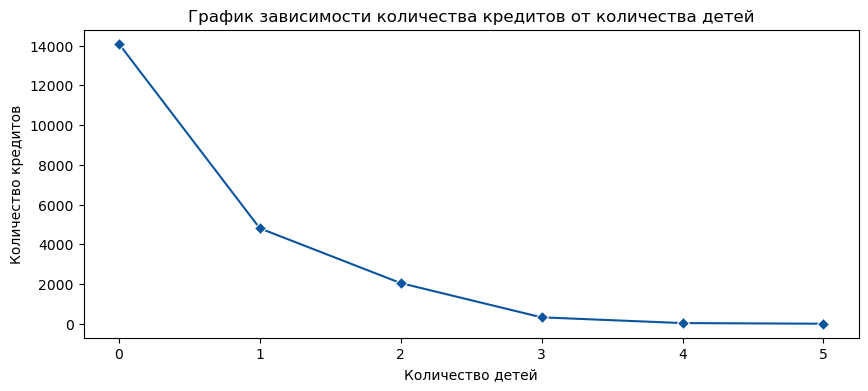

In [73]:
data_ch = df.groupby('children')[['children']].count()

plt.figure(figsize=(10, 4))

sns.lineplot(x=data_ch.index, y=data_ch.children, marker= "D")

plt.title('График зависимости количества кредитов от количества детей')
plt.xlabel('Количество детей')
plt.ylabel('Количество кредитов')
plt.show()

График получился достаточно наглядным: видно, как падает число выданных кредитов в зависимости от числа детей в семье заёмщика. Возможно, это не связано с тем, что многодетные семьи реже берут кредиты. Cемей без детей или с 1–2 детьми намного больше, чем многодетных. В таком случае стоит рассматривать относительные величины.

Сформируем таблицу, отражающую количество выданных кредитов и долю из возвратов в зависимости от количества детей.

In [74]:
df.groupby('children')['debt'].agg(['count', 'sum', 'mean'])

,count,sum,mean
children,,,
0,14090,1063,0.075444
1,4808,444,0.092346
2,2052,194,0.094542
3,330,27,0.081818
4,41,4,0.097561
5,9,0,0.000000


In [75]:
data_pivot = df.groupby('children')['debt'].agg(total_users = 'count', debt = 'sum', share = 'mean').reset_index()
data_pivot['user_share'] = data_pivot['total_users']/data_pivot['total_users'].sum()
data_pivot.style.format({'share' : '{:.1%}', 'user_share' : '{:.1%}' })


,children,total_users,debt,share,user_share
0,0,14090,1063,7.5%,66.1%
1,1,4808,444,9.2%,22.5%
2,2,2052,194,9.5%,9.6%
3,3,330,27,8.2%,1.5%
4,4,41,4,9.8%,0.2%
5,5,9,0,0.0%,0.0%


Оформим результат такой группировки по столбцу и вычисление доли дефолтных кредитов в виде функции `get_share`, которая на вход принимает датафрейм, столбец для группировки, а столбец `debt` для аггрегации значений укажем по умолчанию. Возвращать функция должна таблицу результатов, отражающую значения столбца, по которому выполнялась группировка, количество выданных кредитов, количество дефолтных среди них, долю дефолтных кредитов и долю кредитов в общем числе выданных.

In [76]:
def get_share(df, column, column_to_cal = 'debt'):
    result = df.groupby(column)[column_to_cal].agg(total_users ='count', debts = 'sum', debt_share ='mean').reset_index()
    result['users_share'] = result['total_users']/result['total_users'].sum()
    result

    return result.style.format({'debt_share': '{:.1%}',
                                        'users_share': '{:.1%}'})

In [77]:
get_share(df, 'children')

,children,total_users,debts,debt_share,users_share
0,0,14090,1063,7.5%,66.1%
1,1,4808,444,9.2%,22.5%
2,2,2052,194,9.5%,9.6%
3,3,330,27,8.2%,1.5%
4,4,41,4,9.8%,0.2%
5,5,9,0,0.0%,0.0%


Число выданных кредитов для заемщиков без детей составляет 14090, из которых 1063 имеют просрочку. Доля невозврата кредита для заемщиков без детей составляет 7.5%. Для заемщиков с одним ребенком - 9.2%, с двумя детьми - 9.5%, с тремя детьми - 8.2%, для заемщиков с 4-мя детьми доля невозврата составила 9.8%. Можно сказать, что количество детей не влияет на возврат кредита в срок.

In [78]:
# Сгруппируем данные по столбцу children и выведем на экран общее количество
def debt_share(df, column, column_to_cal = 'debt'):
    result = (df
         .groupby(column, as_index=False)

         .agg(total_users = (column_to_cal,'count'),
              debts = (column_to_cal,'sum'),
              debt_share = (column_to_cal,'mean'))
              .assign(users_share = lambda x: x['total_users']/x['total_users'].sum())
         .sort_values(by=('debt_share'), ascending=False)
            )

    return result.style.format({'debt_share': '{:.1%}',
                                              'users_share': '{:.1%}'})



In [79]:
get_share(df, 'children')

,children,total_users,debts,debt_share,users_share
0,0,14090,1063,7.5%,66.1%
1,1,4808,444,9.2%,22.5%
2,2,2052,194,9.5%,9.6%
3,3,330,27,8.2%,1.5%
4,4,41,4,9.8%,0.2%
5,5,9,0,0.0%,0.0%


**Связь между кредитами и семейным положением**

In [80]:
get_share(df, 'family_status')

,family_status,total_users,debts,debt_share,users_share
0,Не женат / не замужем,2796,273,9.8%,13.1%
1,в разводе,1189,84,7.1%,5.6%
2,вдовец / вдова,951,63,6.6%,4.5%
3,гражданский брак,4133,385,9.3%,19.4%
4,женат / замужем,12261,927,7.6%,57.5%


Наибольшее количество кредитов выдано женатым/замужним заемщикам. Доля возврата кредита в срок для всех категорий примерно одинаковая.
Для заемщиков в статусе вдова/вдовец доля возврата кредита в срок наибольшая , хотя кредитов таким заемщикам выдано наименьшее количество.

Наименьшую долю возврата кредита в срок имеют заемщики в статусе гражданский брак и Не женат / не замужем.

Поэтому можно сказать, что наименее ответвенными заемщиками можно считать заемщиков, состоящих в гражданском браке, или не женатых/ не замужних.

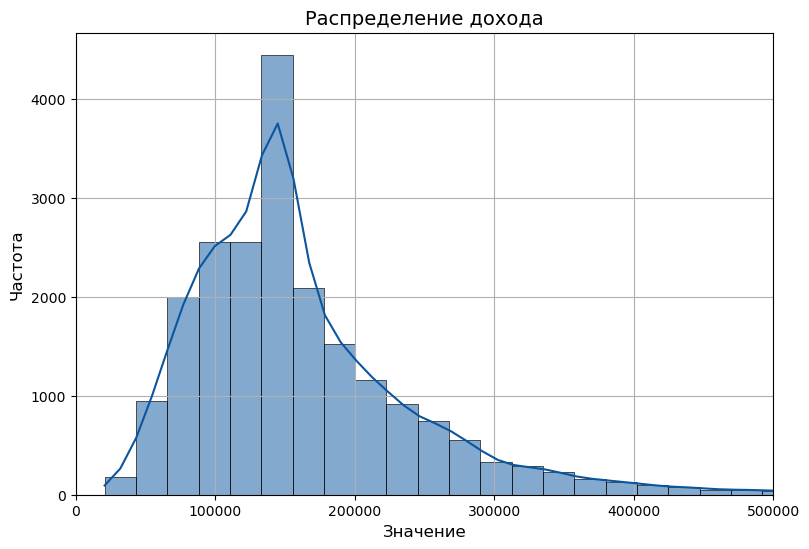

In [81]:
plt.figure(figsize=(9, 6))

sns.histplot(x=df['total_income'], kde=True, bins=100)

plt.xlim(0, 500000)
plt.title('Распределение дохода', fontsize=14)
plt.xlabel('Значение', fontsize=12)
plt.ylabel('Частота', fontsize=12)

plt.grid()
plt.show()

In [82]:
get_share(df, 'total_income_category')

,total_income_category,total_users,debts,debt_share,users_share
0,A,25,2,8.0%,0.1%
1,B,5012,354,7.1%,23.5%
2,C,15922,1353,8.5%,74.6%
3,D,349,21,6.0%,1.6%
4,E,22,2,9.1%,0.1%


Наибольшее количество кредитов выдано заемщикам со средним доходом от 50001 до 200000 (категория С). Доля невозврата кредита в срок для этой категории составила 8.5%. Для заемщиков с высоким доходом 1000001 и выше (категория E)  выдано всего 25 кредитов и только 2 не возвращены в срок. Для заемщиков с доходами от 30001 до 50000 (категория D) доля возврата кредита в срок самая высокая и составляет 94.0%. Тем не менее, можно сказать, что наименее ответвенными заемщиками можно считать заемщиков с доходами ниже 300000.

**Связь между доходом и образованием**

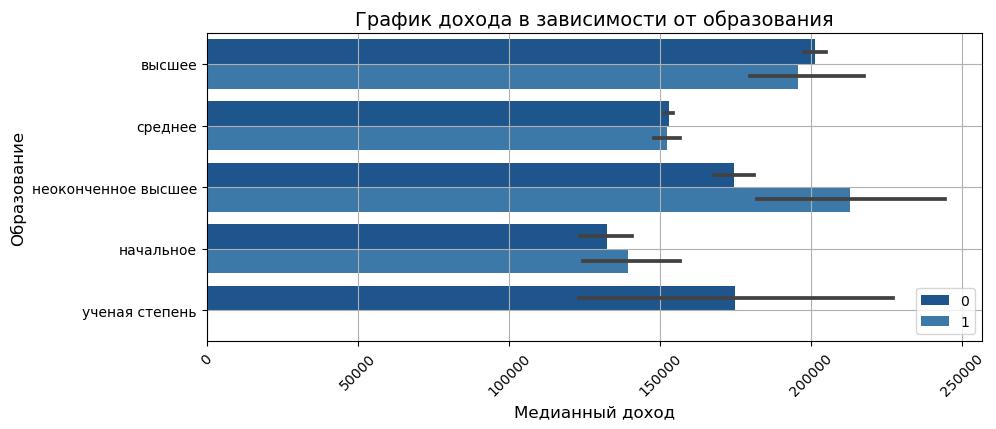

In [83]:
data_ed = df.groupby(['education', 'debt'], \
                        as_index = False)[['total_income']].median()

plt.figure(figsize=(10, 4))

sns.barplot(x = df['total_income'], y=df['education'], hue=df['debt'].astype('str'))

plt.title('График дохода в зависимости от образования', fontsize=14)
plt.xlabel('Медианный доход', fontsize=12)
plt.ylabel('Образование', fontsize=12)
plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize=10)
plt.grid()
plt.show()

Должниками бывают люди и с высшим, и с начальным образованием. Однако среди людей с учёной степенью должников нет вообще

**Связь между целью кредитования и задолженностью**

In [84]:
get_share(df, 'purpose_category')

,purpose_category,total_users,debts,debt_share,users_share
0,Операция с автомобилем,4279,400,9.3%,20.1%
1,операции с недвижемостью,10750,780,7.3%,50.4%
2,получение образованиея,3988,369,9.3%,18.7%
3,проведение свадьбы,2313,183,7.9%,10.8%


Наибольшее количество кредитов выдано для проведения различных операций с недвижимостью. Доля возврата кредита в срок для всех категорий примерно одинаковая. Поэтому нельзя говорить о том, что разные цели кредита влияют на его возврат в срок.

## Шаг 4. Общий вывод

Датасет представляет собой статистику о платёжеспособности клиентов.

Число выданных кредитов для заемщиков без детей составляет 14090, из которых 1063 имеют просрочку. Доля невозврата кредита для заемщиков без детей составляет 7.5%. Для заемщиков с одним ребенком - 9.2%, с двумя детьми - 9.5%, с тремя детьми - 8.2%, для заемщиков с 4-мя детьми доля невозврата составила 9.8%. Можно сказать, что количество детей не влияет на возврат кредита в срок.

Наибольшее количество кредитов выдано для проведения различных операций с недвижимостью. Доля возврата кредита в срок для всех категорий примерно одинаковая. Поэтому нельзя говорить о том, что разные цели кредита влияют на его возврат в срок.

Наибольшее количество кредитов выдано женатым/замужним заемщикам. Доля возврата кредита в срок для всех категорий примерно одинаковая.

Для заемщиков в статусе вдова/вдовец доля возврата кредита в срок наибольшая, хотя кредитов таким заемщикам выдано наименьшее количество.
Наименьшую долю возврата кредита в срок имеют заемщики в статусе гражданский брак и Не женат / не замужем).
Поэтому можно сказать, что наименее ответвенными заемщиками можно считать заемщиков, состоящих в гражданском браке, или не женатых/ не замужних.


Наибольшее количество кредитов выдано заемщикам со средним доходом от 50001 до 200000 (категория С). Доля невозврата кредита в срок для этой категории составила 8.5%. Для заемщиков с высоким доходом 1000001 и выше (категория E)  выдано всего 25 кредитов и только 2 не возвращены в срок. Для заемщиков с доходами от 30001 до 50000 (категория D) доля возврата кредита в срок самая высокая и составляет 94.0%. Тем не менее, можно сказать, что наименее ответвенными заемщиками можно считать заемщиков с доходами ниже 300000.

